# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans



# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter =';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print ('There are {} rows and {} column in the general demoghraphic data'.format(azdias.shape[0], azdias.shape[1]))

There are 891221 rows and 85 column in the general demoghraphic data


In [4]:
print ('There are {} rows (features) and {} column  in the features info'.format(feat_info.shape[0], feat_info.shape[1]))

There are 85 rows (features) and 4 column  in the features info


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
azdias.isnull().sum().sum()

4896838

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info.head(85)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [7]:
azdias.head() #Checking how the codes are represented in the asdias data.

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
#type(azdias['AGER_TYP'][0])

In [9]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [10]:
#type(feat_info['missing_or_unknown'][0])

In [11]:
#feat_info['missing_or_unknown'][0]

In [12]:
def string_to_list(str_list):
    list_missing_or_unknown = str_list.replace('[','')
    list_missing_or_unknown = list_missing_or_unknown.replace(']','')
    
    if not list_missing_or_unknown:
        return list_missing_or_unknown

    list_missing_or_unknown = list_missing_or_unknown.split(',')
    for i in range(len(list_missing_or_unknown)):
        if (list_missing_or_unknown[i] !='X') and list_missing_or_unknown[i] != 'XX':
            list_missing_or_unknown[i] = int(list_missing_or_unknown[i])        
   # list_missing_or_unknown = [int(i) for i in list_missing_or_unknown]
    #print(list_missing_or_unknown)
    return list_missing_or_unknown 
    
#     #print(list_missing_or_unknown[0])
#     list_n = []
#     for i in list_missing_or_unknown:
#         print (i)
#         list_n.append(int(i))
#         print(list_n)
    

feat_info['NAN_values'] = feat_info['missing_or_unknown'].apply(string_to_list) 
type(feat_info['NAN_values'][0][0])

int

In [13]:
#assigned the dataframe azdias to data,changed the missing data code to NAN
data = azdias
for i,col in enumerate(feat_info['attribute']):
    data[col] = data[col].replace(feat_info['NAN_values'][i],np.nan)
#     for q,p in enumerate(data[col]):
#         if p in feat_info['NAN_values'][i]:
#             data[col][q].replace()
#     #data[col]= [np.nan for p in data[col] if p in feat_info['NAN_values'][i]]
    

     

In [14]:
#data.head(10)

In [15]:
#total number of missing or unknown value

print('There are {} missing cells after preprocessing in this phase'.format(data.isnull().sum().sum()))

There are 8373929 missing cells after preprocessing in this phase


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

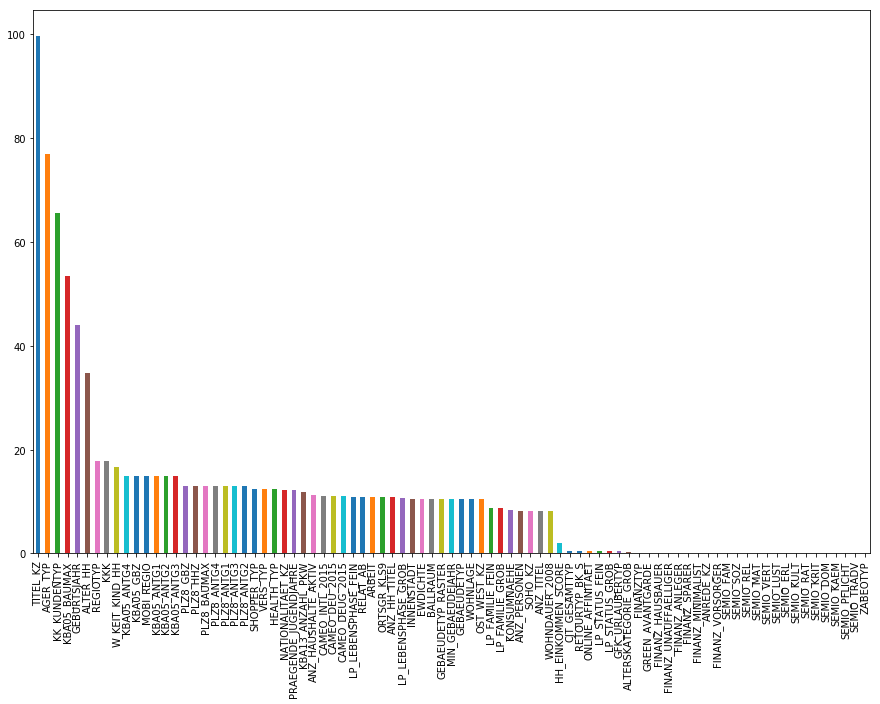

In [16]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
#Compute the number of missing data per column, divide the value by the total number of rows in the data.
#multiply the value by 100
#Sort the values from highest to lowest,
null_per_feature = (data.isnull().sum()/data.shape[0]).sort_values(ascending=False)
percent_null_per_feature = ( null_per_feature * 100)
percent_null_per_feature.plot(kind='bar', figsize=(15,10))

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([  0.        ,   9.97576359,  19.95152717,  29.92729076,
         39.90305435,  49.87881794,  59.85458152,  69.83034511,
         79.8061087 ,  89.78187229,  99.75763587]),
 <a list of 10 Patch objects>)

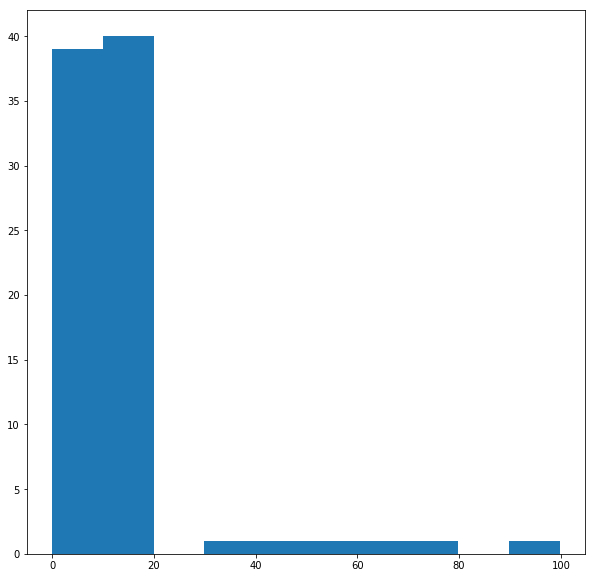

In [17]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize =(10,10))
plt.hist(percent_null_per_feature)


In [18]:
outliers = percent_null_per_feature[0:6].index
outliers

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# outliers = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP','KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']

data = data.drop(labels=outliers,axis=1)

In [20]:
#data.head(40)

In [21]:
column_check = data[['PLZ8_GBZ', 'PLZ8_HHZ', 'PLZ8_BAUMAX','PLZ8_ANTG4','PLZ8_ANTG1', 'PLZ8_ANTG3', 'PLZ8_ANTG2',
                    'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO', 'KBA05_ANTG1', 'KBA05_ANTG2','KBA05_ANTG3']]
column_check.describe()

,PLZ8_GBZ,PLZ8_HHZ,PLZ8_BAUMAX,PLZ8_ANTG4,PLZ8_ANTG1,PLZ8_ANTG3,PLZ8_ANTG2,KBA05_ANTG4,KBA05_GBZ,MOBI_REGIO,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3
count,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000
mean,3.381087,3.612821,1.943913,0.699166,2.253330,1.595426,2.801858,0.305927,3.158580,2.963540,1.494277,1.265584,0.624525
std,1.111598,0.973967,1.459654,0.727137,0.972008,0.986736,0.920309,0.638725,1.329537,1.428882,1.403961,1.245178,1.013443
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000
50%,3.000000,4.000000,1.000000,1.000000,2.000000,2.000000,3.000000,0.000000,3.000000,3.000000,1.000000,1.000000,0.000000
75%,4.000000,4.000000,3.000000,1.000000,3.000000,2.000000,3.000000,0.000000,4.000000,4.000000,3.000000,2.000000,1.000000
max,5.000000,5.000000,5.000000,2.000000,4.000000,3.000000,4.000000,2.000000,5.000000,6.000000,4.000000,4.000000,3.000000


In [22]:
column_check.head(10)

,PLZ8_GBZ,PLZ8_HHZ,PLZ8_BAUMAX,PLZ8_ANTG4,PLZ8_ANTG1,PLZ8_ANTG3,PLZ8_ANTG2,KBA05_ANTG4,KBA05_GBZ,MOBI_REGIO,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,5.0,1.0,1.0,2.0,2.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0
2,4.0,4.0,1.0,0.0,3.0,1.0,3.0,0.0,3.0,3.0,1.0,3.0,1.0
3,4.0,3.0,1.0,0.0,2.0,2.0,2.0,0.0,4.0,4.0,4.0,1.0,0.0
4,3.0,3.0,2.0,1.0,2.0,2.0,4.0,0.0,3.0,3.0,1.0,4.0,1.0
5,5.0,5.0,1.0,1.0,2.0,1.0,3.0,0.0,4.0,4.0,2.0,2.0,0.0
6,5.0,5.0,1.0,0.0,3.0,1.0,3.0,0.0,3.0,5.0,3.0,2.0,0.0
7,4.0,4.0,1.0,0.0,3.0,1.0,3.0,0.0,4.0,4.0,2.0,2.0,0.0
8,3.0,3.0,1.0,1.0,2.0,2.0,3.0,0.0,5.0,3.0,1.0,1.0,0.0
9,3.0,3.0,1.0,1.0,2.0,2.0,3.0,0.0,2.0,3.0,1.0,3.0,1.0


In [23]:
#column_check.head(-50)

#### Discussion 1.1.2: Assess Missing Data in Each Column

in the dataset out of 85 columns 24 had no missing data, implying there are  61 columns with at least a missing data. Out of the 61, 6 columns had missing values above 20%. the column with the highest missing value was 'TITEL_KZ' - which represented academic credit title (Dr. Prof, Dr. Dr etc). 

All columns with missing value percentage greater thatn 20% were droped from the dataset.
the columns are
1. 'TITEL_KZ'
2. 'AGER_TYP' 
3. 'KK_KUNDENTYP'
4. 'KBA05_BAUMAX'
5. 'GEBURTSJAHR'
6. 'ALTER_HH'

The Columns PLZ8_GBZ, PLZ8_HHZ, PLZ8_BAUMAX,PLZ8_ANTG4,PLZ8_ANTG1, PLZ8_ANTG3,PLZ8_ANTG2 all have missing value of 13.073637%. Moving throught the first 40 row of the dataset, it is easily noticed that the Nan values are on the same row.
This would be looked at below.

The columns KBA05_ANTG4,KBA05_GBZ,MOBI_REGIO, KBA05_ANTG1, KBA05_ANTG2,KBA05_ANTG3 also had missing values of 14.959701. Thes columns also show the parasitic Nan value across all columns. 



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# How much data is missing in each row of the dataset?
num_of_row_missing_data = data.isnull().sum(axis = 1). sort_values(ascending = False)
percent_row_missing_data = (num_of_row_missing_data/data.shape[1])*100


#num_of_row_missing_data

(array([  6.97109000e+05,   7.76340000e+04,   1.28010000e+04,
          9.53300000e+03,   8.29000000e+02,   1.55000000e+02,
          1.40160000e+04,   5.03100000e+03,   2.80380000e+04,
          4.60750000e+04]),
 array([  0. ,   4.9,   9.8,  14.7,  19.6,  24.5,  29.4,  34.3,  39.2,
         44.1,  49. ]),
 <a list of 10 Patch objects>)

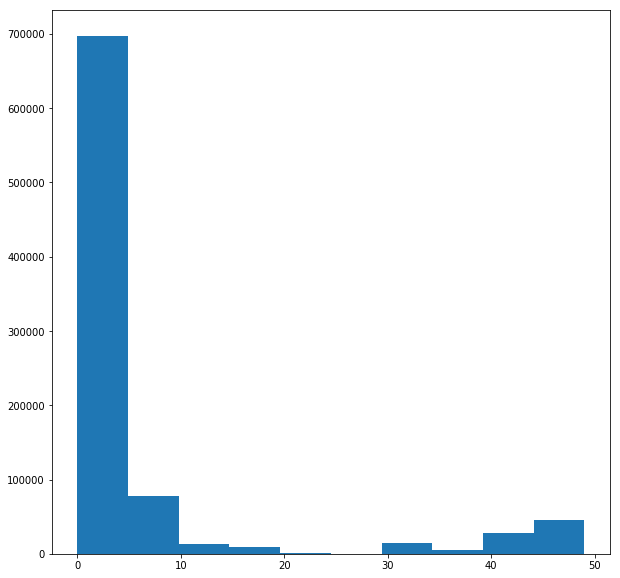

In [25]:
plt.figure(figsize =(10,10))
plt.hist(num_of_row_missing_data)


(array([  6.97109000e+05,   7.76340000e+04,   1.28010000e+04,
          9.53300000e+03,   8.29000000e+02,   1.55000000e+02,
          1.40160000e+04,   5.03100000e+03,   2.80380000e+04,
          4.60750000e+04]),
 array([  0.        ,   6.20253165,  12.40506329,  18.60759494,
         24.81012658,  31.01265823,  37.21518987,  43.41772152,
         49.62025316,  55.82278481,  62.02531646]),
 <a list of 10 Patch objects>)

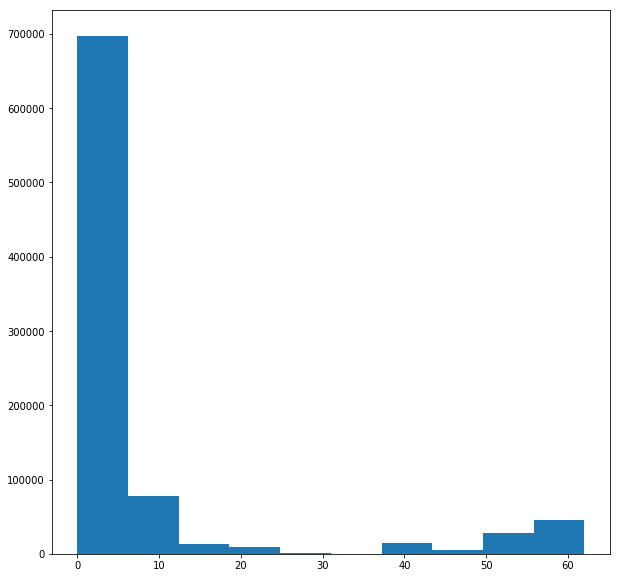

In [26]:
plt.figure(figsize =(10,10))
plt.hist(percent_row_missing_data)


In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 25
rows_above_threshold = data[data.isnull().sum(axis=1) >= threshold]
rows_below_threshold = data[data.isnull().sum(axis=1) < threshold]

print('there are {} rows above {} and {} rows below it'.format(len(rows_above_threshold), threshold, len(rows_below_threshold)))
print('{} % of the data rows have missing field above {} '.format(len(rows_above_threshold)/data.shape[0]*100, threshold))

there are 93315 rows above 25 and 797906 rows below it
10.470466921223805 % of the data rows have missing field above 25 


In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_plot(column_name):
    fig = plt.figure(10, figsize=(12,5))
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('row missing field less than threshold')
    sns.countplot(rows_below_threshold[column_name])
    
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('row missing field greater than threshold')
    sns.countplot(rows_above_threshold[column_name])
                                                       
    fig.suptitle(column_name)
    plt.show()


In [29]:
no_missing_data_col = []
for i in range(null_per_feature.shape[0]):
    if null_per_feature[i] == 0:
        no_missing_data_col.append(null_per_feature.index[i])
no_missing_data_col

['FINANZTYP',
 'GREEN_AVANTGARDE',
 'FINANZ_HAUSBAUER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_ANLEGER',
 'FINANZ_SPARER',
 'FINANZ_MINIMALIST',
 'ANREDE_KZ',
 'FINANZ_VORSORGER',
 'SEMIO_FAM',
 'SEMIO_SOZ',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [30]:
random_col = np.random.randint(0,len(no_missing_data_col)-1,(6) )
print(random_col)

[ 9 14  8 12 22 22]


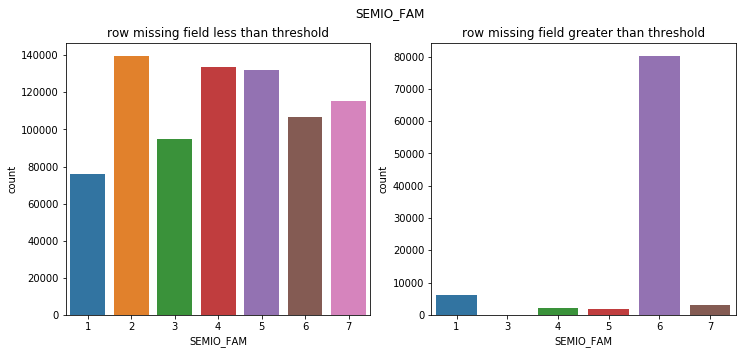

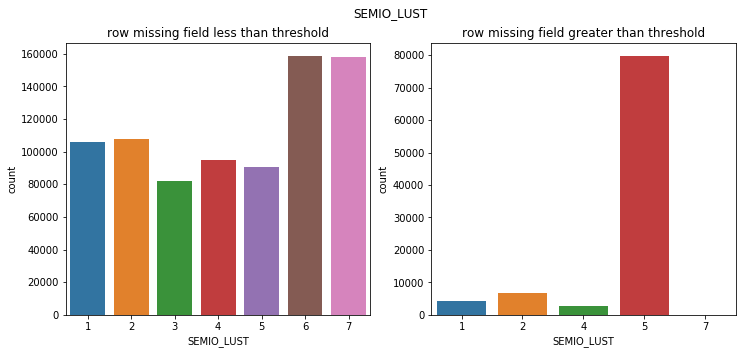

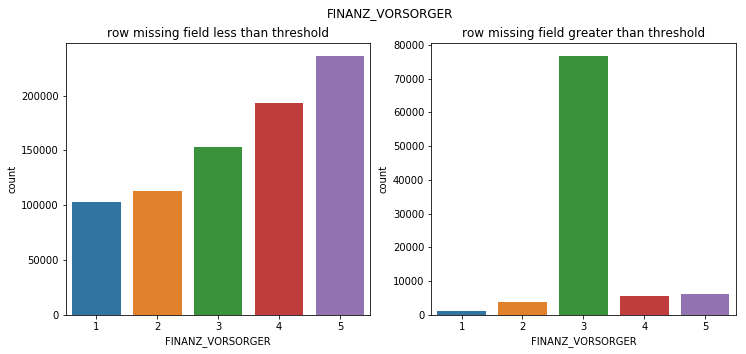

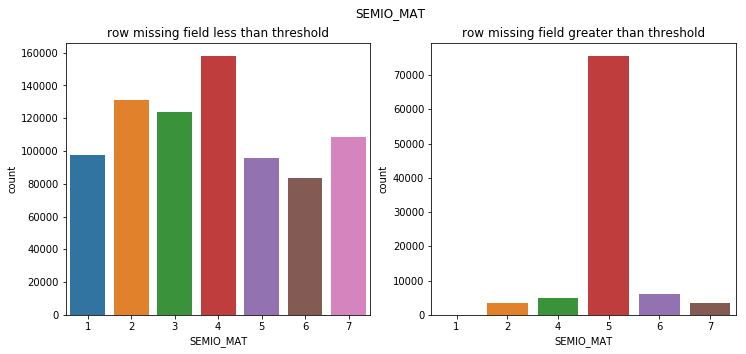

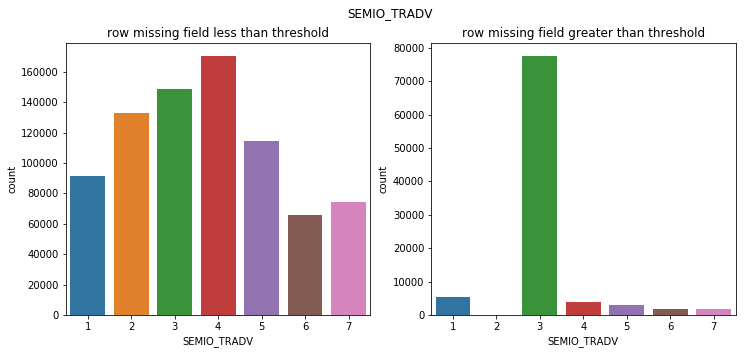

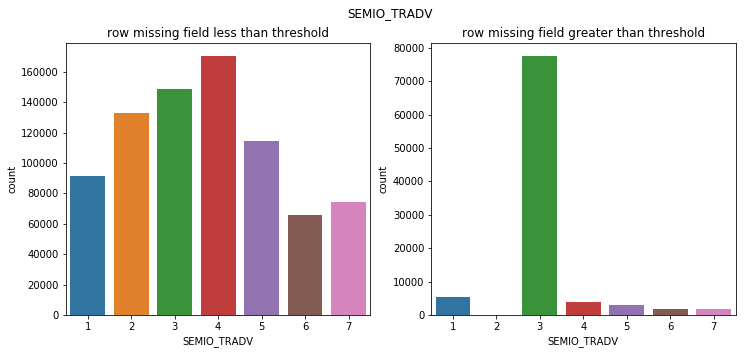

In [31]:
for i in random_col:
    compare_plot(no_missing_data_col[i])

In [32]:
random_col2 = np.random.randint(0,len(no_missing_data_col)-1,(6) )
print(random_col2)

[ 6 14  4  5  3 19]


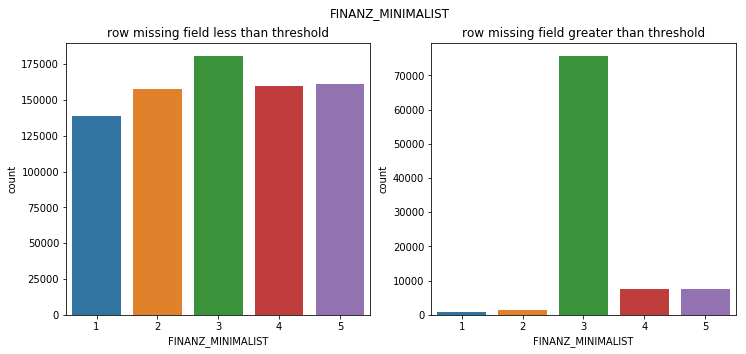

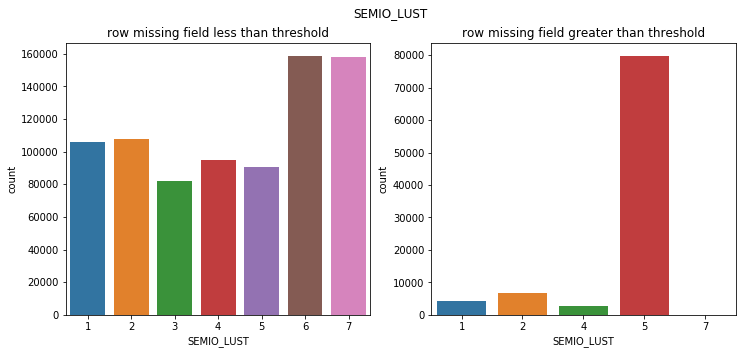

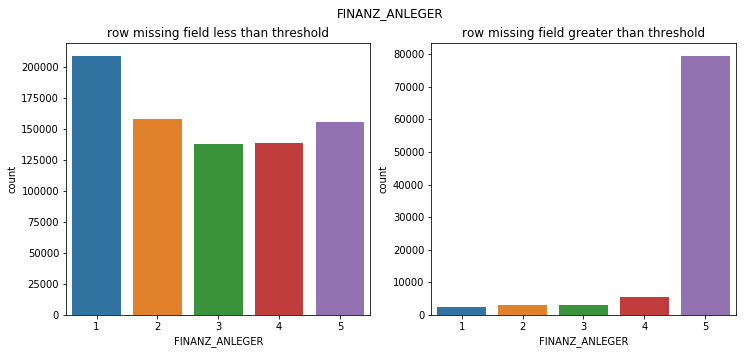

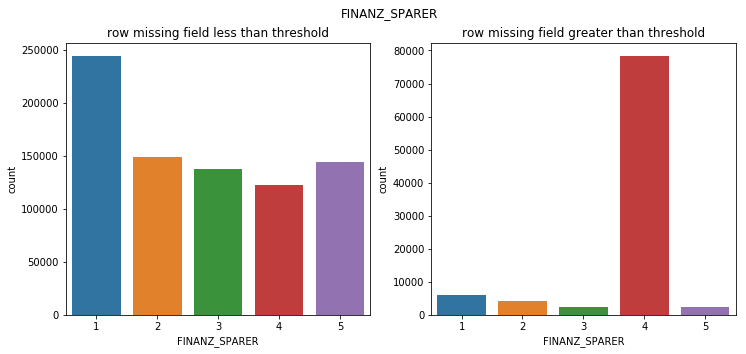

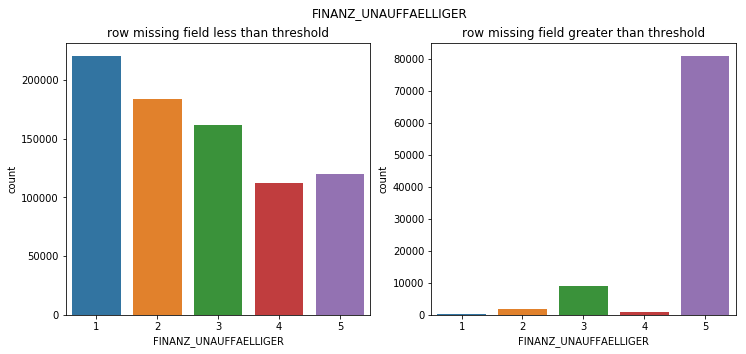

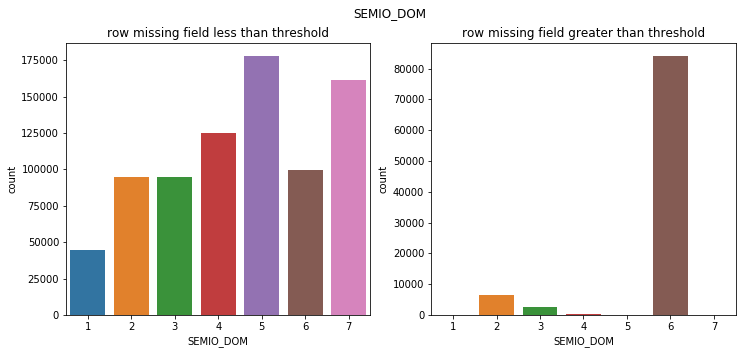

In [33]:
for i in random_col2:
    compare_plot(no_missing_data_col[i])

#### Discussion 1.1.3: Assess Missing Data in Each Row

After ploting various columns and comparing the two groups of missing data, it is quite clear that both groups are not qualitatively equal.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [34]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 5 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
NAN_values            85 non-null object
dtypes: object(5)
memory usage: 3.4+ KB


In [35]:
feat_info = feat_info[feat_info.attribute.isin(list(data.columns.values))]
unique_types, count = np.unique(feat_info['type'], return_counts=True)
unique_types, count

(array(['categorical', 'mixed', 'numeric', 'ordinal'], dtype=object),
 array([18,  6,  6, 49]))

In [36]:
# How many features are there of each data type?
for col_type, count in zip(unique_types, count):
    print('There are {} field with {} data type'.format(count,col_type))



There are 18 field with categorical data type
There are 6 field with mixed data type
There are 6 field with numeric data type
There are 49 field with ordinal data type


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [37]:
#feat_info.head()

In [38]:
cat_attributes=feat_info[feat_info.type=='categorical']

#cat_attributes

In [39]:
binary_cat  =[]
multi_level_cat = []
for col in cat_attributes.attribute:
    if rows_below_threshold[col].nunique()>2:
        multi_level_cat.append(col)
    else:
        binary_cat.append(col)
    
    
# def check_unique_vals(df):
#     for col in df.columns:
#         values = list(df[col].unique())
#         print(f'{col}: {values}')

In [40]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
for col in binary_cat:
    option, count = np.unique(rows_below_threshold[col], return_counts=True)
    print('In', col,'\n')
    print('{}      {}'.format(option,count))



In ANREDE_KZ 

[1 2]      [381817 416089]
In GREEN_AVANTGARDE 

[0 1]      [622698 175208]
In SOHO_KZ 

[ 0.  1.]      [791190   6716]
In VERS_TYP 

[  1.   2.  nan ...,  nan  nan  nan]      [367012 394223      1 ...,      1      1      1]
In OST_WEST_KZ 

['O' 'W']      [168518 629388]


In [41]:
multi_level_cat

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [42]:
rows_below_threshold.drop(['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
                           'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',
                           'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], axis=1,inplace=True)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [43]:
multi_level_cat=[]
multi_level_cat.append('OST_WEST_KZ')
binary_cat.remove('OST_WEST_KZ')

In [44]:
rows_below_threshold.shape#head(10)

(797906, 66)

In [45]:
#rows_below_threshold.shape

In [46]:
#Drop all row that had PLZ8_ANTG1 as Nan

rows_below_threshold = rows_below_threshold.dropna(subset=['PLZ8_ANTG1','KBA05_ANTG4'])

In [47]:
#rows_below_threshold.shape



In [48]:
rows_below_threshold.head (10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2,2,2,5,3,1,5,0,2.0,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


In [49]:
# Re-encode categorical variable(s) to be kept in the analysis.
# OST_WEST_KZ will be added to multilevel categories to be re-encoded
rows_below_threshold = pd.get_dummies(rows_below_threshold, columns=multi_level_cat)



In [50]:
rows_below_threshold.shape

(748448, 67)

In [51]:
rows_below_threshold.columns.values

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW',

#### Discussion 1.2.1: Re-Encode Categorical Features

Therw were  18 categorical features of which 5 were binary. ALL 13 Mixed categorical features were dropped from the dataset. The OST_WEST_KZ was not a numerical binary category so it was and encoded with with pd.get_dummies  

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [52]:
mixed_col= feat_info[feat_info.type =='mixed']
mixed_col

,attribute,information_level,type,missing_or_unknown,NAN_values
15,LP_LEBENSPHASE_FEIN,person,mixed,[0],[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0],[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]","[-1, 0]"
56,WOHNLAGE,building,mixed,[-1],[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]","[-1, XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]","[-1, 0]"


In [53]:
re_encoded_mix = ['LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']


In [54]:
#rows_below_threshold = pd.get_dummies(rows_below_threshold, columns=re_encoded_mix)

### Investigate "PRAEGENDE_JUGENDJAHRE"
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [55]:
def movement (val):
    if val in (1,3,5,8,10,12,14):
        return 0
    elif val in (2,4,6,7,9,11,13,15):
        return 1
    else:
        return np.nan
    
    

In [56]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def decade (val):
    if val in (1,2):
        return 40
    elif val in (3,4):
        return 50
    elif val in (5,6,7):
        return 60
    elif val in (8,9):
        return 70
    elif val in (10,11,12,13):
        return 80
    elif val in (14,15): 
        return 90
    else: 
        return 0


In [57]:
rows_below_threshold['MOVEMENT'] = rows_below_threshold['PRAEGENDE_JUGENDJAHRE'].apply(movement)

In [58]:
rows_below_threshold['DECADE'] = rows_below_threshold['PRAEGENDE_JUGENDJAHRE'].apply(decade)

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [59]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def wealth (val):
    if pd.isnull(val):
        return 0
    tens = int(val)//10   
    return tens
  

In [60]:
def life_stage (val):
    if pd.isnull(val):
        return 0
    digit = int(val) % 10
    return digit

In [61]:
rows_below_threshold['WEALTH'] =rows_below_threshold['CAMEO_INTL_2015'].apply(wealth)

In [62]:
rows_below_threshold['LIFE_STAGE'] =rows_below_threshold['CAMEO_INTL_2015'].apply(life_stage)

In [63]:
rows_below_threshold.shape

(748448, 71)

In [64]:
rows_below_threshold.shape

(748448, 71)

#### Discussion 1.2.2: Engineer Mixed-Type Features


Six features wer of mixed tye. Of the six, 2 were encoded using via custom fuctions. All other features will be dropped from the dataset.
##### Fomatted via custom functions
Features formatted via custom functions are
1. PRAEGENDE_JUGENDJAHRE (Decade and movement) 
2. CAMEO_INTL_2015 ( Life stage and Wealth)

All recoding was done with the help of the data dictionary.

PRAEGENDE_JUGENDJAHRE was encoded into two variable i.e DACADE and MOVEMENT: 
CAMEO_INTL_2015 was encoded into WEALTH and LIFE_STAGE



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [65]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

rows_below_threshold.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
rows_below_threshold.drop('CAMEO_INTL_2015', axis=1, inplace=True)
rows_below_threshold.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
rows_below_threshold.drop(['LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1, inplace=True)



In [66]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

rows_below_threshold.shape

(748448, 65)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [68]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter =';')
    feat_info['NAN_values'] = feat_info['missing_or_unknown'].apply(string_to_list) 
    
       
    # convert missing value codes into NaNs, ...
    for i,col in enumerate(feat_info['attribute']):
        df[col] = df[col].replace(feat_info['NAN_values'][i],np.nan)
    
    outliers = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP','KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df = df.drop(labels=outliers,axis=1)
    print('The shape of the data after removing the outliers is'.format(df.shape))
    # select, re-encode, and engineer column values.
    threshold = 25
    rows_above_threshold_f = df[df.isnull().sum(axis=1) >= threshold]
    rows_below_threshold_f = df[df.isnull().sum(axis=1) < threshold]
    
    feat_info = feat_info[feat_info.attribute.isin(list(df.columns.values))]
    
    
    multi_level_cat = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
                       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',
                       'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    
    rows_below_threshold_f.drop(multi_level_cat, axis=1, inplace=True)      
   
    #print(multi_level_cat)
    rows_below_threshold_f = rows_below_threshold_f.dropna(subset=['PLZ8_ANTG1','KBA05_ANTG4'])
    
    rows_below_threshold_f = pd.get_dummies(rows_below_threshold_f, columns=['OST_WEST_KZ'])
  
    #re_encoded_mix = ['LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

    #rows_below_threshold = pd.get_dummies(rows_below_threshold, columns=re_encoded_mix)
    
    rows_below_threshold_f['MOVEMENT'] = rows_below_threshold_f['PRAEGENDE_JUGENDJAHRE'].apply(movement)
    rows_below_threshold_f['DECADE'] = rows_below_threshold_f['PRAEGENDE_JUGENDJAHRE'].apply(decade)
    
    rows_below_threshold_f['WEALTH'] = rows_below_threshold_f['CAMEO_INTL_2015'].apply(wealth)
    rows_below_threshold_f['LIFE_STAGE'] =rows_below_threshold_f['CAMEO_INTL_2015'].apply(life_stage)
    
    #rows_below_threshold['LP_LEBENSPHASE_FEIN_MA_STATUS'] =rows_below_threshold['LP_LEBENSPHASE_FEIN'].apply(ma_status)
    #rows_below_threshold['LP_LEBENSPHASE_FEIN_AGE_GRADE'] =rows_below_threshold['LP_LEBENSPHASE_FEIN'].apply(age_grade)
    #rows_below_threshold['LP_LEBENSPHASE_FEIN_INCOME_TYPE'] =rows_below_threshold['LP_LEBENSPHASE_FEIN'].apply(income_type)
    
    
    rows_below_threshold_f.drop(['PRAEGENDE_JUGENDJAHRE','LP_LEBENSPHASE_FEIN','CAMEO_INTL_2015',
                               'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1, inplace=True)
    
    
    # Return the cleaned dataframe and the dataframe that is above the threshold.
    return rows_below_threshold_f, rows_above_threshold_f
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [69]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
rows_below_threshold.isnull().sum().sum()


268819

In [70]:

imputer = Imputer(strategy='most_frequent', axis=0)

rows_below_threshold_filled =imputer.fit_transform(rows_below_threshold)

In [71]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
rows_below_threshold_scaled = pd.DataFrame(scaler.fit_transform(rows_below_threshold_filled), columns=rows_below_threshold.columns)

In [72]:
rows_below_threshold_scaled.shape

(748448, 65)

### Discussion 2.1: Apply Feature Scaling

I used the standardScaler as opposed to the min_max Scaler in order to ensure the values are scaled around the mean = 0 and standard deviation =1


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [73]:
# Apply PCA to the data.
pca =PCA()

rows_below_threshold_pca = pca.fit_transform(rows_below_threshold_scaled)

In [74]:
variance = pca.explained_variance_ratio_


In [75]:
# Implement scree_plot based off Udacity defined function
def scree_plot(pca, annotate=False, limit=None, figsize=(14,7)):
    values = pca.explained_variance_ratio_
    if limit:
        values = values[:limit]
    n_components = len(values)
    ind = np.arange(n_components)
    
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    cumvalues = np.cumsum(values)
    ax.bar(ind, values)
    ax.plot(ind, cumvalues)
    if annotate:
        for i in range(n_components):
            ax.annotate(r"%s%%" % ((str(values[i]*100)[:4])), 
                        (ind[i]+0.2, values[i]),
                        va="bottom",
                        ha="center",
                        fontsize=10)
    
    ax.xaxis.set_tick_params(width=3)
    ax.yaxis.set_tick_params(width=2, length=12)
    #ax.yaxis.set_ticks(np.arange(0, 120, 20))
    
    ax.set_xlabel("Principal Component", fontsize=14)
    ax.set_ylabel("Variance Explained (%)", fontsize=14)
    
    if limit:
        plt.title("Explained Variance Per Principle Component for {} Features".format(limit), fontsize=18);
    else:
        plt.title("Explained Variance Per Principle Component", fontsize=18);

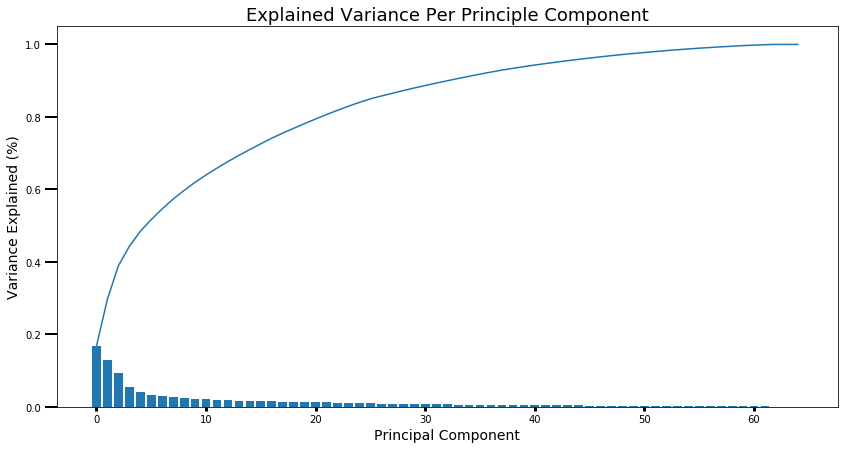

In [76]:
scree_plot(pca)

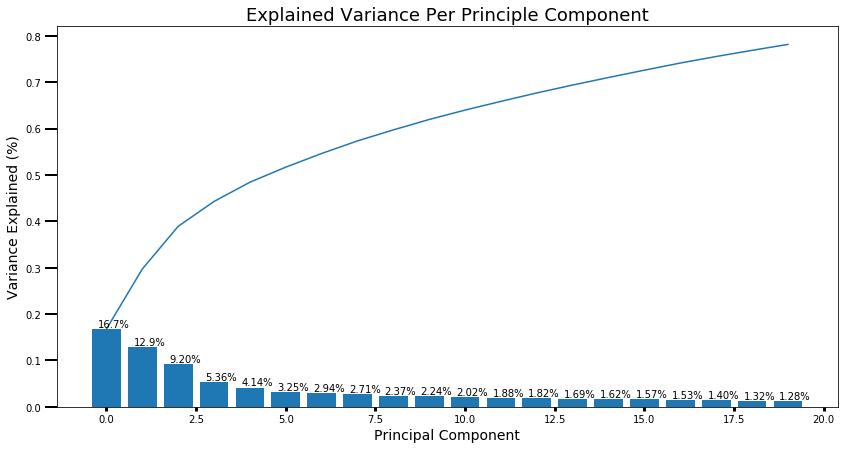

In [77]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_20 = PCA(n_components=20)

rows_below_threshold_pca_20 = pca_20.fit_transform(rows_below_threshold_scaled)


scree_plot(pca_20,True)

In [78]:
def do_pca (X, n_component=None):
    pca = PCA(n_component)
    X_pca = pca.fit_transform(X)
    
    if n_component <=120:
        anote = True
    else:
        anote = False
    scree_plot(pca, anote, n_component)
    return X_pca, pca

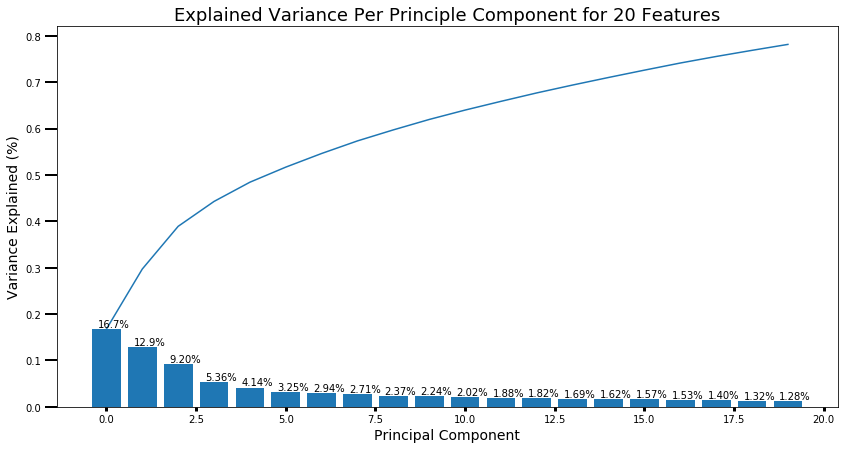

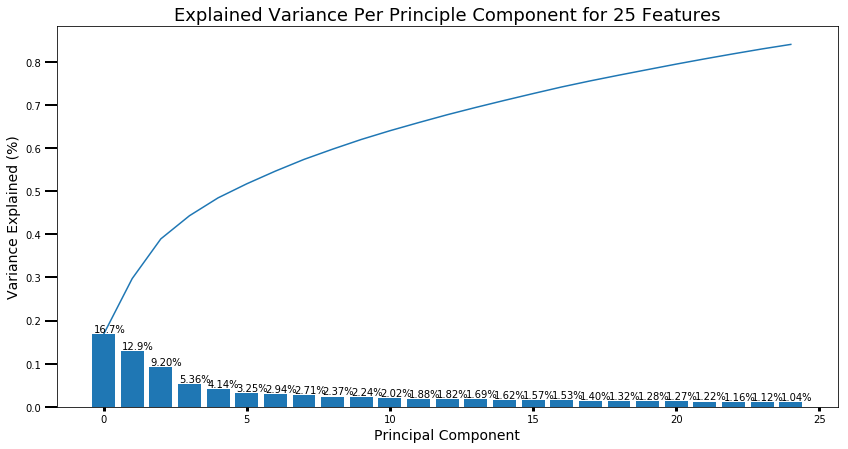

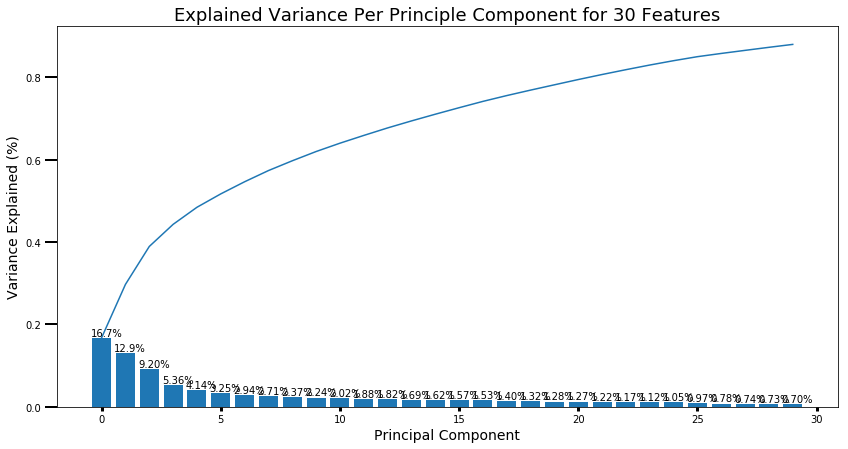

In [79]:
num_components = [20, 25,30,]
for num_component in num_components:
    X_pca_n, pca_n = do_pca(rows_below_threshold_scaled, num_component )
    

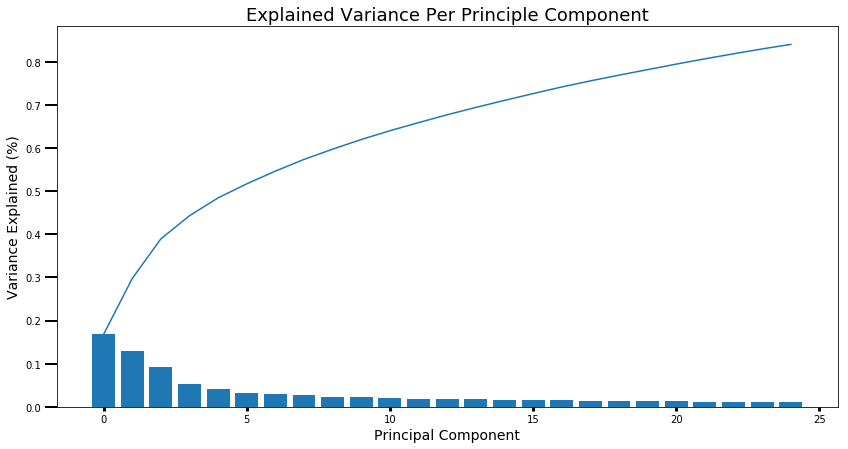

In [80]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_25 = PCA(n_components=25)

rows_below_threshold_pca_25 = pca_25.fit_transform(rows_below_threshold_scaled)


scree_plot(pca_25)

### Discussion 2.2: Perform Dimensionality Reduction

After applying different values to the n_component parameter of PCA, I choose n_component value of 25. From the analysis were values 20, 25 and 30 were compared. At 20 the variance explained was less than 80%, at 25 variance explained was greater than 80% and at 30 it increased slightly. Looking at this 25 n_components is an excellent choice.



### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [81]:
# plots the first and last 6 features that respectively make up the components at n dimensions, and the weights attributed to the features
def plot_component(dataset, pca, dimension):
    component = pd.DataFrame(np.round(pca.components_, 4), columns = dataset.keys()).iloc[dimension-1]
    component.sort_values(ascending=False, inplace=True)
    component= pd.concat([component.head(6), component.tail(6)])
    
    component.plot(kind='bar', title='Components in ' + str(dimension))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()
    
        

In [82]:
#prints the value of the weights of first and last 6 features of components in n dimension
def princ_component (dataset, pca, dimension):
    component = pd.DataFrame(np.round(pca.components_, 4), columns = dataset.keys()).iloc[dimension-1]
    component.sort_values(ascending=False, inplace=True)
    component= pd.concat([component.head(6), component.tail(6)])
    return component

In [83]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

weights_princ_comp = princ_component (rows_below_threshold_scaled, pca_25, 1) 
weights_princ_comp.head(12)

PLZ8_ANTG3            0.2303
PLZ8_ANTG4            0.2235
WEALTH                0.2086
HH_EINKOMMEN_SCORE    0.2056
ORTSGR_KLS9           0.1997
EWDICHTE              0.1970
PLZ8_GBZ             -0.1727
FINANZ_MINIMALIST    -0.2142
KBA05_GBZ            -0.2224
KBA05_ANTG1          -0.2310
PLZ8_ANTG1           -0.2311
MOBI_REGIO           -0.2476
Name: 0, dtype: float64

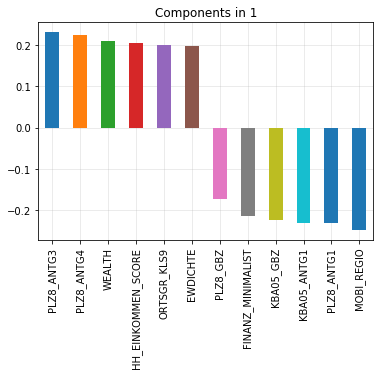

In [84]:
plot_component(rows_below_threshold_scaled, pca_25,1) 

In [85]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_princ_component_2 = princ_component (rows_below_threshold_scaled, pca_25,2) 
weights_princ_component_2.head(12)

ALTERSKATEGORIE_GROB     0.2685
SEMIO_ERL                0.2441
FINANZ_VORSORGER         0.2348
SEMIO_LUST               0.1879
RETOURTYP_BK_S           0.1645
SEMIO_KRIT               0.1289
FINANZ_UNAUFFAELLIGER   -0.2258
SEMIO_KULT              -0.2366
SEMIO_PFLICHT           -0.2368
FINANZ_SPARER           -0.2384
SEMIO_TRADV             -0.2385
SEMIO_REL               -0.2662
Name: 1, dtype: float64

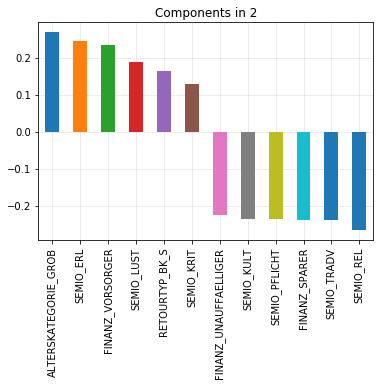

In [86]:
plot_component(rows_below_threshold_scaled, pca_25, 2) 

In [87]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_princ_component_3 = princ_component (rows_below_threshold_scaled, pca_25, 3) 
weights_princ_component_3.head(12)


SEMIO_VERT           0.3470
SEMIO_SOZ            0.2606
SEMIO_FAM            0.2400
SEMIO_KULT           0.2201
FINANZ_MINIMALIST    0.1634
RETOURTYP_BK_S       0.1178
FINANZ_ANLEGER      -0.1979
SEMIO_RAT           -0.2289
SEMIO_KRIT          -0.2667
SEMIO_DOM           -0.3127
SEMIO_KAEM          -0.3350
ANREDE_KZ           -0.3667
Name: 2, dtype: float64

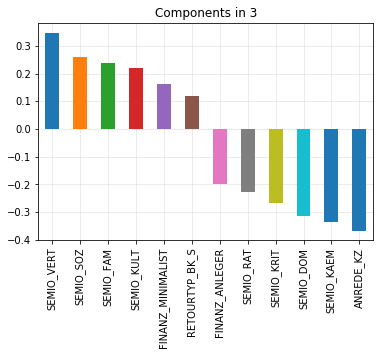

In [88]:
plot_component(rows_below_threshold_scaled, pca_25, 3) 

In [89]:
rows_below_threshold_scaled.shape

(748448, 65)

### Discussion 2.3: Interpret Principal Components

From the weights attached to each feature, it is seen that different features matter differntly to the components. SEMIO_KULT and SEMIO_KULT however appered in the within the first and last 6 feature of dimension 2 and 3


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [90]:
def kmeans_clustering (n_cluster, X):
    kmeans = KMeans(n_cluster)
    model = kmeans.fit(X)
    score = np.abs(model.score(X))
    print (score)
    return score

In [91]:
kmeans_clustering(3, rows_below_threshold_pca_25)

31697035.7976


31697035.797616206

In [97]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
 
# compute the average within-cluster distances.
    
#cluster_labels ={i:kmeans_clustering(i, rows_below_threshold_pca_90) for i in range(2,20)}
cluster_scores = []

for i in range (2,26):
    cluster_scores.append(kmeans_clustering(i, rows_below_threshold_pca_25))

34702999.3569
31699092.8975
29852647.46
28510482.3529
27282515.5251
26252629.8656
25476606.525
24904665.3321
24354991.873
23765233.1875
23461658.0553
23036692.9469
22527445.765
22253079.5202
22035995.8393
21596146.6258
21170084.8908
20906810.5051
20578795.9541
20532747.8909
20256946.7739
19939069.5946
19943546.0767
19625713.0233


In [ ]:
# for i in range (20,26):
#     cluster_scores.append(kmeans_clustering(i, rows_below_threshold_pca_90))

Text(0.5,1,'No of clusters Vs Average distance')

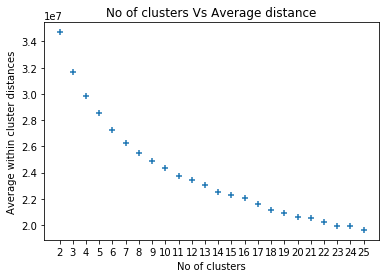

In [98]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.scatter(range(2,26), cluster_scores, marker='+')
plt.xticks(np.arange(2, 26, step=1))
plt.xlabel('No of clusters')
plt.ylabel('Average within cluster distances')
plt.title ('No of clusters Vs Average distance')

In [92]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 16)
model = kmeans.fit(rows_below_threshold_pca_25)
predict_general = model.predict(rows_below_threshold_pca_25)


### Discussion 3.1: Apply Clustering to General Population

Above the model was tried with different values of clusters i.e 2-25. The score of each was thenplotted in the graph above. From the plot, the slope steepness is seen to begin to reduce at around 10. This however continues to descend slowly until the change becomes very minute at 16 untile it reaches 25 clusters. I choose 16 clusters because i believe this is the stage were the change in the score is minimal.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [93]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')


In [94]:
#Apply preprocessing
customers_data, above_threshold = clean_data(customers)

The shape of the data after removing the outliers is


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [95]:
customers_data.shape

(134734, 65)

In [96]:
#removing all nans
customers_data_filled =imputer.transform(customers_data)

In [97]:
# Apply scaling function
customers_data_scaled = pd.DataFrame(scaler.transform(customers_data_filled), columns=customers_data.columns)

In [98]:
#PCA
#pca_customer = PCA(90)
customers_data_pca = pca_25.transform(customers_data_scaled)


In [99]:
#kmeans = KMeans(16)
predict_customer = kmeans.predict(customers_data_pca)


In [100]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [101]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
gen_above = (rows_above_threshold.shape[0]/data.shape[0]) * 100

cust_above = (above_threshold.shape[0]/customers.shape[0]) * 100

general_cluster, gen_counts = np.unique(predict_general, return_counts=True)
gen_props = np.array([(gen_counts/len(predict_general))*100]).flatten()


customer_cluster, cust_counts = np.unique(predict_customer, return_counts=True)
cust_props = np.array([(cust_counts/len(predict_customer))*100]).flatten()


print(gen_above)


10.470466921223805


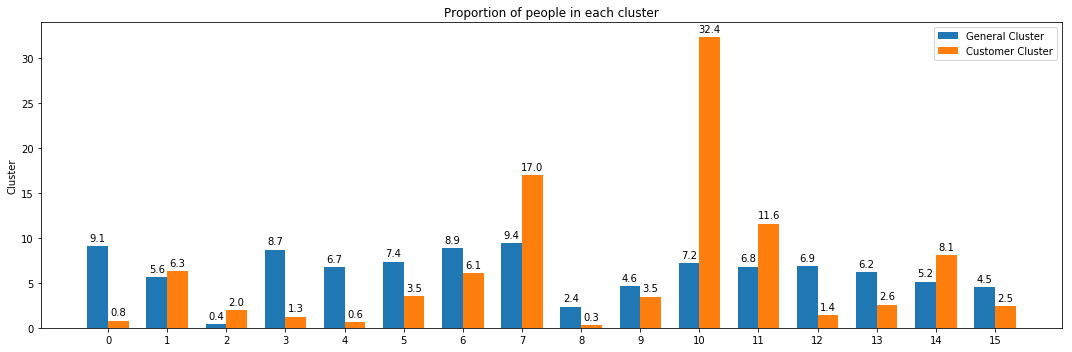

In [102]:
# Reference https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html

fig, ax = plt.subplots(figsize=(15,5))

x = np.arange(len(general_cluster))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, gen_props, width, label='General Cluster')
rects2 = ax.bar(x + width/2, cust_props, width, label='Customer Cluster')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Cluster')
ax.set_title('Proportion of people in each cluster')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend()


def autolabel(rects, props):
    """Attach the proportion of people in the cluster above each bar in *rects*, displaying its height."""
    for rect,prop in zip(rects,props):
        height = rect.get_height()
        ax.annotate('{}'.format(prop),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1,np.round(gen_props,1))
autolabel(rects2,np.round(cust_props,1))

fig.tight_layout()

plt.show()

In [103]:
print(gen_above,'\n')
print(cust_above)

10.470466921223805 

26.063385719950745


In [113]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# clusters overrepresented in the customer cluster 10.


pca_gen_inv = pca_25.inverse_transform(rows_below_threshold_pca_25[predict_general == 10])
inv_gen_scale = scaler.inverse_transform(pca_gen_inv)
general_data = pd.DataFrame(inv_gen_scale, columns = rows_below_threshold.columns).round()



In [114]:
pca_cust_inv = pca_25.inverse_transform(customers_data_pca[predict_customer == 10 ])
inv_cust_scale = scaler.inverse_transform(pca_cust_inv)
customer_data = pd.DataFrame(inv_cust_scale, columns =customers_data.columns).round()



In [115]:
general_data.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
count,54210.000000,54210.000000,54210.000000,54210.000000,54210.00000,54210.000000,54210.000000,54210.000000,54210.000000,54210.000000,...,54210.000000,54210.000000,54210.000000,54210.000000,54210.000000,54210.000000,54210.000000,54210.000000,54210.000000,54210.000000
mean,3.320181,1.000609,4.798100,1.648054,4.22577,1.528242,2.207600,1.901974,0.988139,2.142317,...,3.928685,2.992603,5.265726,2.920808,0.095979,0.904021,0.988139,66.057554,2.027689,3.584099
std,0.607066,0.024665,0.574974,0.859820,0.91539,0.933800,0.860436,0.831338,0.108263,0.806582,...,0.874710,0.977226,1.618047,1.319841,0.294565,0.294565,0.108263,12.363711,0.782417,1.155327
min,1.000000,1.000000,1.000000,0.000000,1.00000,-1.000000,0.000000,-1.000000,-0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-0.000000,27.000000,0.000000,-1.000000
25%,3.000000,1.000000,5.000000,1.000000,4.00000,1.000000,2.000000,1.000000,1.000000,1.000000,...,3.000000,2.000000,4.000000,2.000000,-0.000000,1.000000,1.000000,56.000000,2.000000,3.000000
50%,3.000000,1.000000,5.000000,1.000000,4.00000,1.000000,2.000000,2.000000,1.000000,2.000000,...,4.000000,3.000000,5.000000,3.000000,0.000000,1.000000,1.000000,65.000000,2.000000,4.000000
75%,4.000000,1.000000,5.000000,2.000000,5.00000,2.000000,3.000000,2.000000,1.000000,3.000000,...,5.000000,4.000000,6.000000,4.000000,0.000000,1.000000,1.000000,75.000000,2.000000,4.000000
max,5.000000,2.000000,6.000000,5.000000,6.00000,5.000000,6.000000,5.000000,1.000000,4.000000,...,6.000000,5.000000,9.000000,6.000000,1.000000,1.000000,1.000000,111.000000,5.000000,6.000000


In [116]:
customer_data.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
count,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,...,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000,43650.000000
mean,3.531638,1.000023,4.977411,1.242222,4.708018,1.116220,1.930355,2.091249,0.988683,1.874204,...,3.886827,2.879129,5.228316,2.901993,0.035464,0.964536,0.988683,59.624101,1.988133,3.707491
std,0.569945,0.004786,0.454226,0.567874,0.632022,0.767615,0.641210,0.730925,0.105780,0.798034,...,0.863564,0.970814,1.625127,1.309464,0.184951,0.184951,0.105780,10.159495,0.782197,1.126689
min,1.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,-1.000000,-0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,-0.000000,0.000000,-0.000000,27.000000,0.000000,0.000000
25%,3.000000,1.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,1.000000,1.000000,...,3.000000,2.000000,4.000000,2.000000,0.000000,1.000000,1.000000,52.000000,1.000000,3.000000
50%,4.000000,1.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,1.000000,2.000000,...,4.000000,3.000000,5.000000,3.000000,0.000000,1.000000,1.000000,58.000000,2.000000,4.000000
75%,4.000000,1.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,1.000000,3.000000,...,5.000000,4.000000,6.000000,4.000000,0.000000,1.000000,1.000000,65.000000,2.000000,4.000000
max,5.000000,2.000000,6.000000,5.000000,6.000000,5.000000,5.000000,5.000000,1.000000,4.000000,...,6.000000,5.000000,9.000000,6.000000,1.000000,1.000000,1.000000,109.000000,5.000000,6.000000


In [117]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
pca_gen_inv = pca_25.inverse_transform(rows_below_threshold_pca_25[predict_general ==0])
inv_gen_scale = scaler.inverse_transform(pca_gen_inv)
general_data = pd.DataFrame(inv_gen_scale, columns = rows_below_threshold.columns).round()

pca_cust_inv = pca_25.inverse_transform(customers_data_pca[predict_customer == 0 ])
inv_cust_scale = scaler.inverse_transform(pca_cust_inv)
customer_data = pd.DataFrame(inv_cust_scale, columns =customers_data.columns).round()




In [118]:
general_data.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
count,68028.000000,68028.000000,68028.000000,68028.000000,68028.000000,68028.000000,68028.000000,68028.000000,68028.000000,68028.000000,...,68028.000000,68028.000000,68028.000000,68028.000000,68028.000000,68028.000000,68028.000000,68028.000000,68028.000000,68028.000000
mean,1.514200,1.999103,1.169857,4.278429,2.182293,4.120656,3.586185,4.214412,0.037558,2.283251,...,2.710575,3.680235,7.006071,3.747883,0.281399,0.718601,0.037558,85.247075,4.338640,2.060255
std,0.586114,0.029932,0.666756,0.872174,0.860509,0.886172,0.883631,0.756979,0.190126,0.605018,...,0.936081,0.683380,1.534567,0.946470,0.449685,0.449685,0.190126,8.882757,0.761038,1.403854
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,2.000000,0.000000,-0.000000,-0.000000,0.000000,38.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000,4.000000,2.000000,4.000000,3.000000,4.000000,-0.000000,2.000000,...,2.000000,3.000000,6.000000,3.000000,0.000000,0.000000,-0.000000,81.000000,4.000000,1.000000
50%,1.000000,2.000000,1.000000,4.000000,2.000000,4.000000,4.000000,4.000000,0.000000,2.000000,...,3.000000,4.000000,7.000000,4.000000,0.000000,1.000000,0.000000,87.000000,4.000000,1.000000
75%,2.000000,2.000000,1.000000,5.000000,2.000000,5.000000,4.000000,5.000000,0.000000,3.000000,...,3.000000,4.000000,8.000000,4.000000,1.000000,1.000000,0.000000,91.000000,5.000000,3.000000
max,3.000000,2.000000,4.000000,6.000000,6.000000,6.000000,6.000000,7.000000,1.000000,4.000000,...,6.000000,5.000000,10.000000,6.000000,1.000000,1.000000,1.000000,113.000000,6.000000,6.000000


In [119]:
customer_data.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
count,1085.000000,1085.0,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,...,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000
mean,1.564977,2.0,1.773272,3.351152,3.011982,3.270046,2.834101,4.130876,0.094931,2.295853,...,2.538249,3.584332,7.314286,3.691244,0.257143,0.742857,0.094931,79.364055,4.192627,2.289401
std,0.591038,0.0,0.876205,1.312448,1.286764,1.158108,1.318383,0.813525,0.293255,0.566623,...,0.870627,0.666498,1.484181,0.866327,0.437260,0.437260,0.293255,12.618121,0.777177,1.511069
min,1.000000,2.0,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,1.000000,...,1.000000,1.000000,3.000000,1.000000,-0.000000,-0.000000,0.000000,42.000000,2.000000,0.000000
25%,1.000000,2.0,1.000000,2.000000,2.000000,2.000000,2.000000,4.000000,-0.000000,2.000000,...,2.000000,3.000000,6.000000,3.000000,0.000000,0.000000,-0.000000,72.000000,4.000000,1.000000
50%,2.000000,2.0,2.000000,4.000000,3.000000,3.000000,3.000000,4.000000,0.000000,2.000000,...,3.000000,4.000000,8.000000,4.000000,0.000000,1.000000,0.000000,82.000000,4.000000,1.000000
75%,2.000000,2.0,2.000000,4.000000,4.000000,4.000000,4.000000,5.000000,0.000000,3.000000,...,3.000000,4.000000,9.000000,4.000000,1.000000,1.000000,0.000000,89.000000,5.000000,4.000000
max,3.000000,2.0,4.000000,5.000000,6.000000,6.000000,5.000000,6.000000,1.000000,3.000000,...,6.000000,5.000000,10.000000,6.000000,1.000000,1.000000,1.000000,103.000000,6.000000,6.000000


### Discussion 3.3: Compare Customer Data to Demographics Data

From the above analysis the two deductions below were made.

1. People with very high money saving tendencies are more popular in the customer group of the company. This can be seen in the FINANZ_ANLEGER and FINANZ_SPARER which shows that over 50% of the overrepresented customer cluster have high money saving tendencies and very high investing tendencies. 

2. Most of the people in the over 75% of the people in the overrepresented customer cluster are members of the environmental sustainability group  GREEN_AVANTGARDE. This is seen in the GREEN_AVANTGARDE feature and the movement feature. Members of GREEN_AVANTGARDE OF moved to GREEN_AVANTGARDE is represented as 1 for both column. This is in opposition to zero represented in the under represented cluster.

And finally the ratio of customers that were above the treshold for missing data was more than thos in the general demographics data.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

#### References

1. https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
2. https://pandas.pydata.org/docs/index.html/
3. https://scikit-learn.org/stable/modules/impute.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
5. https://builtin.com/data-science/step-step-explanation-principal-component-analysis
6.https://stackoverflow.com/
7. Udacity helper functions for this course.